We first note that the L function is monotonically decreasing. We can observe this by seeing L from linespace -4 to 4:

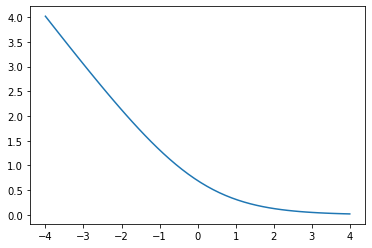

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-4,4)
plt.plot(x, np.log(1+np.exp(-x)))
plt.show()

Because the function is monotonic decreasing that means that maximizing the function applied to a scalar is equivalent to applying the function to the minimization of the inner scalar. In other words $max_{||\delta||_\infty\leq\epsilon}L(y*(w^T(x+\delta)+b)) = L(min_{||\delta||_\infty\leq\epsilon}y*(w^T(x+\delta)+b))$ We can then distribute out the $w^T$ and the $y$ to get $L(min_{||\delta||_\infty\leq\epsilon}y*w^Tx+y*w^T\delta+y*b)$. Since only $y*w^T\delta$ depends on $\delta$ this means that this can further be reduced to $L(y*w^Tx+y*b+min_{||\delta||_\infty\leq\epsilon}y*w^T\delta)$ which then further reduces to $L(y*(w^Tx+b)+min_{||\delta||_\infty\leq\epsilon}y*w^T\delta)$. Now, all we need to solve is $min_{||\delta||_\infty\leq\epsilon}y*w^T\delta$. To solve this let us consider the case where $y=+1$. Due to the $l_\infty$ norm constraint meaning that each element in $\delta$ must have magnitude less than or equal to $\epsilon$, we then clearly minimize this quantity when $\delta = -\epsilon$ for $w_i >= 0$ and $\delta = \epsilon$ for $w_i < 0$. For $y = -1$ we would just flip these quantaties. We can then express this mathematically by saying that the argmin for $\delta$ of in other words $\delta^*$ is $-y$ time $\epsilon$ times the sign of $w_i$ so $\delta^* = -y\epsilon*sign(w)$. Since we know that $min_{||\delta||_\infty\leq\epsilon}y*w^T\delta$ is just $y*w^T\delta^*$ we can substitute our value o $\delta^*$ and also multiply it out with $w^T$ to get $y*\sum_{i=1}-y\epsilon*sign(w_i)w_i$. We then take out $-y\epsilon$ and note that $sign(w_i)*w_i = |w_i|$ to get $-y^2\epsilon\sum_i|w_i|$. No matter what the value of y is, since, $y \in \{+1,-1\}$ that means that $y^2 = 1$. $\sum_i|w_i|$ is also just the l1 norm of $w$. finally we now know that $min_{||\delta||_\infty\leq\epsilon}y*w^T\delta = -\epsilon||w||_1$. This means that the entire maximization function has the value $max_{||\delta||_\infty\leq\epsilon}L(y*(w^T(x+\delta)+b)) = L(y*(w^Tx+b)-\epsilon||w||_1)$ which means that the the entire problem just becomes a simple minimization function: $min_{w,b}\frac{1}{D}\sum_{(x,y)\in D}L(y*(w^Tx+b)-\epsilon||w||_1)$ which is convex in w and b so can be solved exactly.

In [3]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
dataset = datasets.FashionMNIST(os.getcwd(), download=True, train=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=1)
validset = datasets.FashionMNIST(os.getcwd(), download=True, train=False, transform=transforms.ToTensor())
validloader = torch.utils.data.DataLoader(validset, batch_size=128, shuffle=True, num_workers=1)

100.0%


Extracting /mnt/c/Users/fanga2/Documents/MLOPProject/PGDAdversarialLearning/scripts/FashionMNIST/raw/train-images-idx3-ubyte.gz to /mnt/c/Users/fanga2/Documents/MLOPProject/PGDAdversarialLearning/scripts/FashionMNIST/raw



100.6%


Extracting /mnt/c/Users/fanga2/Documents/MLOPProject/PGDAdversarialLearning/scripts/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /mnt/c/Users/fanga2/Documents/MLOPProject/PGDAdversarialLearning/scripts/FashionMNIST/raw



100.0%


Extracting /mnt/c/Users/fanga2/Documents/MLOPProject/PGDAdversarialLearning/scripts/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /mnt/c/Users/fanga2/Documents/MLOPProject/PGDAdversarialLearning/scripts/FashionMNIST/raw



119.3%


Extracting /mnt/c/Users/fanga2/Documents/MLOPProject/PGDAdversarialLearning/scripts/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /mnt/c/Users/fanga2/Documents/MLOPProject/PGDAdversarialLearning/scripts/FashionMNIST/raw



In [7]:
from model import LeNet5

In [11]:
import train

In [12]:
model_basic = LeNet5(10)
model_adv = LeNet5(10)

In [13]:
from pgd_attack import LinfPGDAttack

In [15]:
basic_atk = LinfPGDAttack(model=model_basic, epsilon=0.0313725, num_steps=5, step_size=2.0, random_start = True, device=device)
adv_atk = LinfPGDAttack(model=model_adv, epsilon=0.0313725, num_steps=5, step_size=2.0, random_start = True, device=device)

In [18]:
acc_basic_basic = []
loss_basic_basic = []
acc_basic_adv = []
loss_basic_adv = []
loss_function_basic = nn.CrossEntropyLoss()
optimizer_basic = torch.optim.Adam(model_basic.parameters(), lr=.01)

In [ ]:
for epoch in range(0, 20):
    train.train_one_epoch(model_basic, loss_function_basic, optimizer_basic, trainloader, None, device)
    nat_ret, adv_ret = train.evaluate(model_basic, loss_function_basic, validloader, basic_atk, device)
    loss_basic_basic.append(nat_ret[0])
    acc_basic_basic.append(nat_ret[1])
    loss_basic_adv.append(adv_ret[0])
    acc_basic_adv.append(adv_ret[1])

In [17]:
acc_adv_basic = []
loss_adv_basic = []
acc_adv_adv = []
loss_adv_adv = []
loss_function_adv = nn.CrossEntropyLoss()
optimizer_adv = torch.optim.Adam(model_basic.parameters(), lr=.01)

In [ ]:
for epoch in range(0,20):
    train.train_one_epoch(model_adv, loss_function_adv, optimizer_adv, trainloader, adv_atk, device)
    nat_ret, adv_ret = train.evaluate(model_adv, loss_function_adv, validloader, adv_atk, device)
    loss_adv_basic.append(nat_ret[0])
    acc_adv_basic.append(nat_ret[1])
    loss_adv_adv.append(adv_ret[0])
    acc_adv_adv.append(adv_ret[1])

In [ ]:
epochs = np.arange(1,21)
plt.title("Accuracy of the nueral netwrok without adverserial training over epochs.")
plt.plot(epochs, acc_basic_basic, label="basic input", linestyle='-', marker='^', color = 'r')
plt.plot(epochs, acc_basic_adv, label="adverserial input", linestyle='-', marker='*', color = 'g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
plt.title("Loss of the nueral netwrok without adverserial training over epochs.")
plt.plot(epochs, loss_basic_basic, label="basic input", linestyle='-', marker='^', color = 'r')
plt.plot(epochs, loss_basic_adv, label="adverserial input", linestyle='-', marker='*', color = 'g')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [ ]:
plt.title("Accuracy of the nueral netwrok with adverserial training over epochs.")
plt.plot(epochs, acc_adv_basic, label="basic input", linestyle='-', marker='^', color = 'r')
plt.plot(epochs, acc_adv_adv, label="adverserial input", linestyle='-', marker='*', color = 'g')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

In [ ]:
plt.title("Loss of the nueral netwrok without adverserial training over epochs.")
plt.plot(epochs, loss_adv_basic, label="basic input", linestyle='-', marker='^', color = 'r')
plt.plot(epochs, loss_adv_adv, label="adverserial input", linestyle='-', marker='*', color = 'g')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

Some comments